In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import librosa

In [3]:
input_path = "mp3_input/bass_NEICD.mp3"

audio, sr = librosa.load(input_path)

In [4]:
hop_length = 512 # default

In [5]:
f0 = librosa.yin(y=audio, fmin=40, fmax=400, sr=sr)
times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

In [6]:
# Convert frequencies → MIDI notes
def hz_to_midi(hz):
    if hz <= 0 or np.isnan(hz):
        return None
    return int(round(69 + 12 * np.log2(hz / 440.0)))

midi_notes = [hz_to_midi(freq) for freq in f0]

In [7]:
midi_notes

[43,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 43,
 42,
 39,
 52,
 51,
 51,
 27,
 39,
 39,
 39,
 39,
 33,
 39,
 33,
 32,
 32,
 32,
 51,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 39,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 33,
 32,
 33,
 27,
 65,
 46,
 46,
 46,
 66,
 37,
 28,
 28,
 28,
 27,
 28,
 27,
 28,
 28,
 28,
 46,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 35,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 35,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 33,
 33,
 32,
 31,
 30,
 30,
 29,
 37,
 38,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,


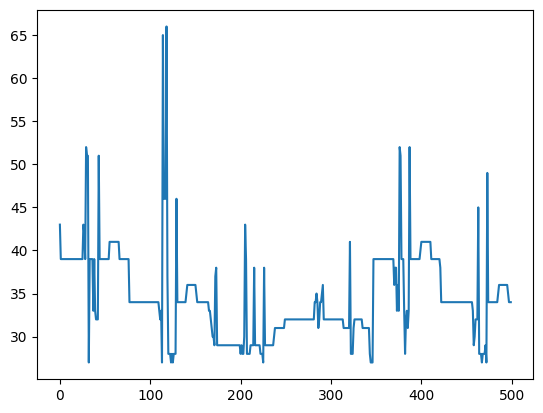

In [8]:
plt.plot(midi_notes[:500])

In [15]:
noise_window = 1

# build midi from sequence of midi notes 
# Build MIDI file
midi = pretty_midi.PrettyMIDI()
bass_program = pretty_midi.instrument_name_to_program("Acoustic Bass")
bass = pretty_midi.Instrument(program=bass_program)

# Group frames into sustained notes
current_note = None
note_start = None

for i, note in enumerate(midi_notes):
    if note is not None:
        if current_note is None:  # new note
            current_note = note
            note_start = times[i]
        elif not((current_note - noise_window) < note < (current_note + noise_window)):  # pitch change → close old note, start new
            bass.notes.append(pretty_midi.Note(
                velocity=100, pitch=current_note,
                start=note_start, end=times[i]
            ))
            current_note = note
            note_start = times[i]
    else:
        if current_note is not None:  # end current note
            bass.notes.append(pretty_midi.Note(
                velocity=100, pitch=current_note,
                start=note_start, end=times[i]
            ))
            current_note = None
            note_start = None

# If song ends with a note still playing
if current_note is not None:
    bass.notes.append(pretty_midi.Note(
        velocity=100, pitch=current_note,
        start=note_start, end=times[-1]
    ))

midi.instruments.append(bass)

In [16]:
midi.write("transcribed_output/bass_output.mid")